# Check the property of device and versions

In [1]:
# !pip install -U "transformers>=4.43.0"

In [2]:
import torch
torch.cuda.is_available()

True

In [3]:
!python --version

Python 3.12.8


In [4]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [5]:
# Run the following to empty the VRAM:
import gc
import torch
# del model, tokenizer, pipe

# Flush memory
gc.collect()
torch.cuda.empty_cache()

In [6]:
!nvidia-smi

Tue Apr  8 08:05:18 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.06             Driver Version: 570.124.06     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A10                     Off |   00000000:81:00.0 Off |                    0 |
|  0%   31C    P8             23W /  150W |       4MiB /  23028MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Document Preprocessing

In [7]:
# use the Class
from embed_from_file import EmbeddingFromFile

# Call the class
pdf_path = ["articles/TafsirIbnKathir.pdf"]
embedder = EmbeddingFromFile(pdf_path= pdf_path, 
                             embed_path="articles/text_chunks_and_embeddings_df.csv",
                            device = "cuda")

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [8]:
# Create markeddown text using pymupdf4llm
md_text = embedder.markeddown_text(page_chunks=True, show_progress=True)

Processing articles/TafsirIbnKathir.pdf...
]========================================] (5698/5698)


In [9]:
# Creating dictionary with page num, token num, content and sentences using NLP LLM model
pages_text = embedder.page_and_text(md_text,first_page= 1)

Processing TafsirIbnKathir.pdf: 100%|██████████| 5697/5697 [00:17<00:00, 323.51it/s]


In [10]:
# Creating chunked
chunked = embedder.create_chunk(pages_and_texts = pages_text, slice_size=8)

# Filtered dataset excluding chunks less than certain number of tokens
filtered = embedder.df_with_min_chunk_length(pages_and_chunks=chunked, min_token_length=10)

Creating Chunks: 100%|██████████| 5697/5697 [00:00<00:00, 30923.45it/s]


In [11]:
# Creating embedding and pandas dataframe and saved the embeddings
df_with_embeddings = embedder.sentence_embeddings(filtered, model="intfloat/multilingual-e5-base")

/home/jovyan/RAG/rag_env/lib/python3.12/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Generating Embeddings: 100%|██████████| 12330/12330 [03:19<00:00, 61.88it/s]


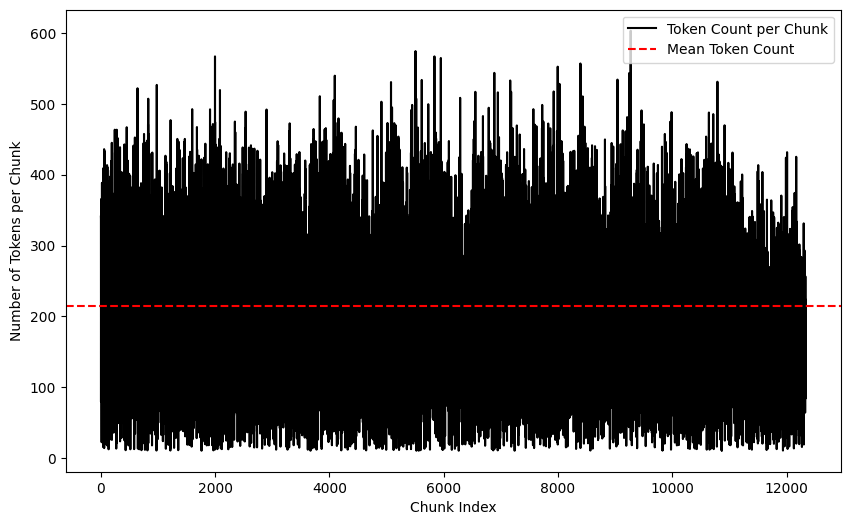

In [12]:
# Plotting the stats i.e., chunk index vs token per chunks
embedder.plot_stats()

In [13]:
import random

random.sample(chunked, k=2)

[{'document_name': 'TafsirIbnKathir.pdf',
  'page_number': 4057,
  'sentence_chunk': 'The Command to say Salah upon the Prophet   Al-Bukhari said: "Abu Al-` Aliyah said: "Allah\'s Salah is His praising him before the angels, and the Salah of the angels is their supplication.\'\' Ibn ` Abbas said: "They send blessings.\'\' Abu ` Isa At-Tirmidhi said: "This was narrated from Sufyan Ath-Thawri and other scholars, who said: ` The Salah of the Lord is mercy, and the Salah of the angels is their seeking forgiveness. There are Mutawatir Hadiths narrated from the Messenger of Allah commanding us to send blessings on him and how we should say Salah upon him. We will mention as many of them as we can, if Allah wills, and Allah is the One Whose help we seek. In his Tafsir of this Ayah, Al-Bukhari recorded that Ka` b bin ` Ujrah said, "It was said, ` O Messenger of Allah, with regard to sending Salam upon you, we know about this, but how about Salah\' He said:  ∩∃ギｚヨ∠エ⊥ョ ⌒メへ ヴ∠ヤ∠ハ∠ヱ ∃ギｚヨ∠エ⊥ョ ヴ∠ヤ∠ハ

# RAG - Search and Retrieval

### Load the saved embedded dataframe

In [14]:
import random

import torch
import numpy as np 
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

# Import texts and embedding df
text_chunks_and_embedding_df = pd.read_csv("articles/text_chunks_and_embeddings_df.csv")

# Convert embedding column back to np.array (it got converted to string when it got saved to CSV)
text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# Convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")

# Convert embeddings to torch tensor and send to device (note: NumPy arrays are float64, torch tensors are float32 by default)
embeddings = torch.tensor(np.array(text_chunks_and_embedding_df["embedding"].tolist()), dtype=torch.float32).to(device)
embeddings.shape

torch.Size([12330, 768])

### Load the sentense fransformer model and create embedding from saved CSV file or alternatively, use the previously saved embedding.

In [15]:
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="intfloat/multilingual-e5-base", 
                                      device=device) # choose the device to load the model to

/home/jovyan/RAG/rag_env/lib/python3.12/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [16]:
# Define helper function to print wrapped text 
import textwrap
from time import perf_counter as timer

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5,
                                print_time: bool=True):
    """
    Embeds a query with model and returns top k scores and indices from embeddings.
    """
    # Embed the query
    query_embedding = model.encode(query, 
                                   convert_to_tensor=True) 

    # Get dot product scores on embeddings
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

    scores, indices = torch.topk(input=dot_scores, 
                                 k=n_resources_to_return)

    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
    """
    Takes a query, retrieves most relevant resources and prints them out in descending order.

    Note: Requires pages_and_chunks to be formatted in a specific way (see above for reference).
    """
    
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)
    
    print(f"Query: {query}\n")
    print("Results:")
    # Loop through zipped together scores and indicies
    for score, index in zip(scores, indices):
        print(f"Score: {score:.4f}")
        # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
        print_wrapped(pages_and_chunks[index]["sentence_chunk"])
        # Print the page number too so we can reference the textbook further and check the results
        print(f"Page number: {pages_and_chunks[index]['page_number']}")
        print("\n")

In [17]:
query = "When did battle of Badr happend?"

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

[INFO] Time taken to get scores on 12330 embeddings: 1.09831 seconds.


(tensor([0.8402, 0.8341, 0.8319, 0.8268, 0.8266], device='cuda:0'),
 tensor([3998, 1709, 3856, 4017,  181], device='cuda:0'))

In [18]:
# Print out the texts of the top scores
print_top_results_and_scores(query=query,
                             embeddings=embeddings)

[INFO] Time taken to get scores on 12330 embeddings: 0.00006 seconds.
Query: When did battle of Badr happend?

Results:
Score: 0.8402
On the day of Badr when the idolators came with their forces and supplies, he
said to his Companions, «チ∇ケ∠ほ∇ャや∠ヱ ⊥れや∠ヲ∠ヨｚジャや ゅ∠ヰ⊥ッ∇ゲ∠ハ ∃るｚレ∠ィ ヴ∠ャ⌒ま やヲ⊥ョヲ⊥ホ»
-----
Page number: 2010


Score: 0.8341
(And Allah has already made you victorious at Badr,)�3:123� meaning, during the
battle of Badr, which occurred on a Friday, the seventeenth of Ramadan, in the
second year of Hijrah.  The day of Badr is known as Yawm Al-Furqan �the Day of
the Clarification�, by which Allah gave victory and dominance to Islam and its
people and disgraced and destroyed Shirk, even though the Muslims were few. The
Muslims numbered three hundred and thirteen men, with two horses and seventy
camels. The rest were foot soldiers without enough supplies for the battle. The
enemy army consisted of nine hundred to a thousand men, having enough shields
and supplies, battle-ready horses an

## Check device 

In [19]:
# Get GPU available memory
import torch
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes / (2**30))
print(f"Available GPU memory: {gpu_memory_gb} GB")

Available GPU memory: 22 GB


In [20]:
# Run the following to empty the VRAM:
import gc
import torch
# del model, tokenizer, pipe

# Flush memory
gc.collect()
torch.cuda.empty_cache()

# Load huggingface Text Generation LLM

In [21]:
# huggingface-cli download meta-llama/Llama-3.2-1B-Instruct --include "original/*" --local-dir Llama-3.2-1B-Instruct


In [22]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
model_name = "Qwen/Qwen2.5-1.5B-Instruct"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token

# Load model
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", trust_remote_code=False)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### Check the model size and memory requirements

In [23]:
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

get_model_num_params(model)

1543714304

In [24]:
def get_model_mem_size(model: torch.nn.Module):
    """
    Get how much memory a PyTorch model takes up.

    See: https://discuss.pytorch.org/t/gpu-memory-that-model-uses/56822
    """
    # Get model parameters and buffer sizes
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

    # Calculate various model sizes
    model_mem_bytes = mem_params + mem_buffers # in bytes
    model_mem_mb = model_mem_bytes / (1024**2) # in megabytes
    model_mem_gb = model_mem_bytes / (1024**3) # in gigabytes

    return {"model_mem_bytes": model_mem_bytes,
            "model_mem_mb": round(model_mem_mb, 2),
            "model_mem_gb": round(model_mem_gb, 2)}

get_model_mem_size(model)

{'model_mem_bytes': 7114388480, 'model_mem_mb': 6784.81, 'model_mem_gb': 6.63}

# Text Generation using LLM using RAG

In [25]:
manual_questions = ["Who is bound to pay Jakat?",
                    "When did battle of badr occured?",
                    "Who will enter the paradise first?"
    
]


query_list = manual_questions

In [26]:
import random
# query = random.choice(query_list)
query = query_list[0]

print(f"Query: {query}")

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

Query: Who is bound to pay Jakat?
[INFO] Time taken to get scores on 12330 embeddings: 0.00010 seconds.


(tensor([0.7954, 0.7951, 0.7933, 0.7916, 0.7911], device='cuda:0'),
 tensor([ 7848, 10594,   863,  8183,  4179], device='cuda:0'))

In [27]:
def prompt_formatter(query: str, 
                     context_items: list[dict]) -> str:
    """
    Augments query with text-based context from context_items.
    """
    # Join context items into one dotted paragraph
    context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])

    # Create a base prompt with examples to help the model
    # Note: this is very customizable, I've chosen to use 3 examples of the answer style we'd like.
    # We could also write this in a txt file and import it in if we wanted.
    base_prompt = """
    Based on the following context items, please answer the query.
    Give yourself room to think by extracting relevant passages from the context before answering the query.
    Don't return the thinking, only return the answer.
    Use the following examples as reference for the ideal answer style.
    \nExample 1:
    Query: What are the fat-soluble vitamins?
    Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood clotting and bone metabolism.
    \nNow use the following context items to answer the user query:
    {context}
    \nRelevant passages: <extract relevant passages from the context here>
    User query: Make sure your answers are as concise as possible. {query}
    Answer:
    """

    # Update base prompt with context items and query   
    base_prompt = base_prompt.format(context=context, query=query)

    # Create prompt template for instruction-tuned model
    dialogue_template = [
        {"role": "user",
        "content": base_prompt}
    ]

    # Apply the chat template
    prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                          tokenize=False,
                                          add_generation_prompt=True)
    return prompt

In [28]:
def ask(query, 
        temperature=0.7,
        max_new_tokens=512,
        format_answer_text=True, 
        return_answer_only=True):
    """
    Takes a query, finds relevant resources/context and generates an answer to the query based on the relevant resources.
    """
    
    # Get just the scores and indices of top related results
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings)
    
    # Create a list of context items
    context_items = [pages_and_chunks[i] for i in indices]

    # Add score to context item
    for i, item in enumerate(context_items):
        item["score"] = scores[i].cpu() # return score back to CPU 
        
    # Format the prompt with context items
    prompt = prompt_formatter(query=query,
                              context_items=context_items)
    
    # Tokenize the prompt
    input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

    # Generate an output of tokens
    outputs = model.generate(**input_ids,
                                 temperature=temperature,
                                 do_sample=True,
                                 max_new_tokens=max_new_tokens)
    
    # Turn the output tokens into text
    output_text = tokenizer.decode(outputs[0])

    if format_answer_text:
        # Replace special tokens and unnecessary help message
        output_text = output_text.replace(prompt, "").replace("<bos>", "").replace("<eos>", "").replace("Sure, here is the answer to the user query:\n\n", "")

    # Only return the answer without the context items
    if return_answer_only:
        return output_text
    
    return output_text, context_items

In [29]:
# query = random.choice(query_list)
query = query_list[1]
print(f"Query: {query}")

# Answer query with context and return context 
answer, context_items = ask(query=query, 
                            temperature=0.7,
                            max_new_tokens=512,
                            return_answer_only=False)

print(f"Answer:\n")
print_wrapped(answer)

Query: When did battle of badr occured?
[INFO] Time taken to get scores on 12330 embeddings: 0.00006 seconds.
Answer:

The battle of Badr occurred on a Friday, the seventeenth of Ramadan, in the
second year of Hijrah.<|im_end|>


In [42]:
print(f"Context items:")
# context_items

Context items:


# Evaluation

### see this blog about LaaJ: https://arize.com/blog-course/llm-as-a-judge/

How can LLM-as-a-Judge be used for RAG Applications? 

Contextual relevance and faithfulness are two of the most widely-used metrics for assessing the accuracy and relevance of retrieved files of documents when leveraging LLM RAG.

In [40]:
## Generate a dataframe for all the queries from query_list

eval_df = []
temperature = 0.7  # Define temperature if it's not dynamic

for ii in range(len(query_list)):
    query = query_list[ii]

    # Answer query with context and return context 
    answer, context_items = ask(query=query, 
                                temperature=temperature,
                                max_new_tokens = 512,
                                return_answer_only=False)

    eval_df.append({
        "query": query,
        "temperature": temperature,
        "answer": answer.replace('<|im_end|>', '').replace('**', ''),
        "context_items": "\n".join(["".join(item['sentence_chunk']) for item in context_items]), # paragraph
        "page_number": [item['page_number'] for item in context_items] # page
    })

[INFO] Time taken to get scores on 12330 embeddings: 0.00006 seconds.
[INFO] Time taken to get scores on 12330 embeddings: 0.00007 seconds.
[INFO] Time taken to get scores on 12330 embeddings: 0.00008 seconds.


In [41]:
eval_df = pd.DataFrame(eval_df)
eval_df.head()

,query,temperature,answer,context_items,page_number
0,Who is bound to pay Jakat?,0.7,"According to the context, the category of peop...","""On the day of the Conquest ぴof Makkahび I was ...","[3784, 5028, 432, 3942, 2099]"
1,When did battle of badr occured?,0.7,"The Battle of Badr occurred on a Friday, the s...",On the day of Badr when the idolators came wit...,"[2010, 853, 1936, 1928, 2019]"
2,Who will enter the paradise first?,0.7,"According to the information provided, those w...","(till when they reach it,) means, when they ar...","[4405, 3066, 5112, 2511, 1239]"


In [43]:
ii = 0
print(eval_df['query'][ii],"\n\n" ,eval_df['answer'][ii], "\n\n" ,eval_df['context_items'][ii])

Who is bound to pay Jakat? 

 According to the context, the category of people obligated to pay Zakah (alms) includes:

1. The poor (Fuqarā')
2. The needy (Masīkin)
3. Those employed to collect funds
4. To attract the hearts of those who have been inclined towards Islam
5. To free slaves
6. For debts
7. For Allah's cause
8. For Ibn 'As-Sabil
9. Duties imposed by Allah

These categories are responsible for paying Zakah according to the ruling described in the verse (60:10). 

 "On the day of the Conquest ぴof Makkahび I was walking alongside the Messenger of Allah as he was riding, and he said some very beautiful words, including the following:  ⊥ヮ∠ャ∠ヱ ⌒リ∇Β∠ゎｚゲ∠ョ ⊥ロ⊥ゲ∇ィ∠ぺ ⊥ヮ∠ヤ∠プ ⌒リ∇Β∠よゅ∠わ⌒ム∇ャや ⌒モ∇ワ∠ぺ ∇リ⌒ョ ∠ユ∠ヤ∇シ∠ぺ ∇リ∠ョ» ∠リΒ⌒ミ⌒ゲ∇ゼ⊥ヨ∇ャや ∠リ⌒ョ ∠ユ∠ヤ∇シ∠ぺ ∇リ∠ョ∠ヱ ゅ∠レ∇Β∠ヤ∠ハ ゅ∠ョ ⌒ヮ∇Β∠ヤ∠ハ∠ヱ ゅ∠レ∠ャ ゅ∠ョ «ゅ∠レ∇Β∠ヤ∠ハ ゅ∠ョ ⌒ヮ∇Β∠ヤ∠ハ∠ヱ ゅ∠レ∠ャ ゅ∠ョ ⊥ヮ∠ャ∠ヱ ⊥ロ⊥ゲ∇ィ∠ぺ ⊥ヮ∠ヤ∠プ  (Whoever among the people of the two Books becomes Muslim, he will have his reward twice, and he has the same rights and duties as we do. Whoe

### Re-check the context from the original Tafsir

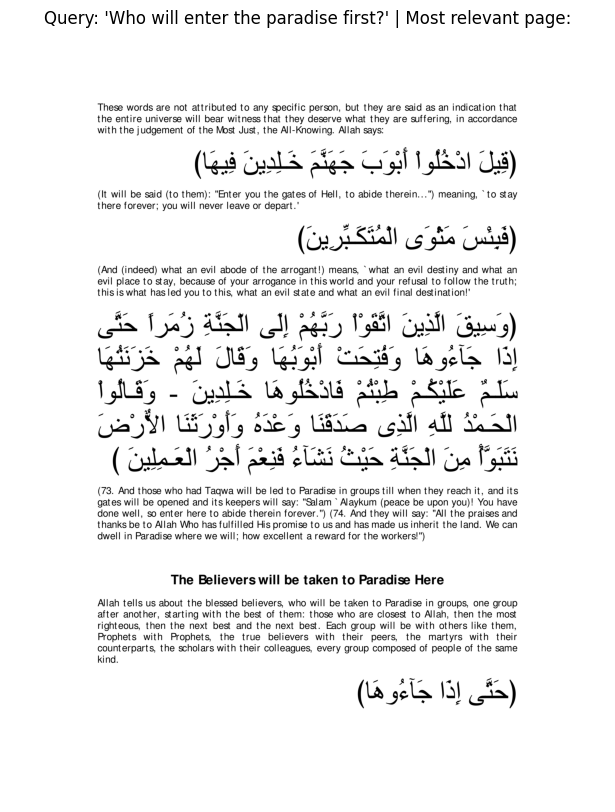

In [45]:
import fitz

# Open PDF and load target page
pdf_path = "articles/TafsirIbnKathir.pdf" # requires PDF to be downloaded
doc = fitz.open(pdf_path)
page = doc.load_page(4405 - 1) # number of page 

# Get the image of the page
img = page.get_pixmap(dpi=300)

# Optional: save the image
#img.save("output_filename.png")
doc.close()

# Convert the Pixmap to a numpy array
img_array = np.frombuffer(img.samples_mv, 
                          dtype=np.uint8).reshape((img.h, img.w, img.n))

# Display the image using Matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis('off') # Turn off axis
plt.show()